In [1]:
## This notebook tests the angular accuracy and magnitude metric

In [2]:
"""
This script calculates for a trial, the average direction error for each target aquisition 

"""
# function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from sklearn.decomposition import PCA
from sklearn import linear_model
sys.path.insert(0,'/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaces')
from lib_streamAndRenderDataWorkflows.config_streaming import renderingBodyParts

colorMap =  [
    'red',         # Standard named color
    '#FFA07A',     # Light Salmon (hexadecimal)
    'blue',        # Standard named color
    '#00FA9A',     # Medium Spring Green (hexadecimal)
    'green',       # Standard named color
    '#FFD700',     # Gold (hexadecimal)
    'purple',      # Standard named color
    '#87CEFA',     # Light Sky Blue (hexadecimal)
    'orange',      # Standard named color
    '#FF69B4',     # Hot Pink (hexadecimal)
    'cyan',        # Standard named color
    '#8A2BE2',     # Blue Violet (hexadecimal)
    'magenta',     # Standard named color
    '#20B2AA',     # Light Sea Green (hexadecimal)
    'brown',       # Standard named color
    '#D2691E',     # Chocolate (hexadecimal)
    'pink',        # Standard named color
    '#6495ED'      # Cornflower Blue (hexadecimal)
]

def calcThetha(y_curr,y_prev,x_curr,x_prev):
    dY = y_curr - y_prev
    dX = x_curr - x_prev
    if dY == 0 and dX == 0:
        #print('zero detected')
        raise(ZeroDivisionError)
    alpha = np.abs(np.arctan((y_curr - y_prev)/(x_curr - x_prev)))
    if dY >= 0 and dX >= 0:
        return alpha
    elif dY >= 0 and dX <= 0:
        return np.pi - alpha
    elif dY <= 0 and dX >= 0:
        return 2 * np.pi -alpha
    elif dY <= 0 and dX <= 0:
        return  np.pi + alpha
    
def calcMag(y_curr,y_prev,x_curr,x_prev):
    dY = y_curr - y_prev
    dX = x_curr - x_prev
    return np.sqrt(np.square(dY) + np.square(dX))


def calcDirAvgForMovingToTarget(cursorPos,timeStamps):
    thethas = []
    for i in range(5,len(cursorPos[:,0]),5):
        try:
            thethas.append((calcThetha(cursorPos[i,1],cursorPos[i-5,1],cursorPos[i,0],cursorPos[i-5,0])) * (timeStamps[i]-timeStamps[i-5]))
        except ZeroDivisionError:
            pass
    return (sum(thethas))/(timeStamps[-1] - timeStamps[0])

def calcMagAvgForMovingToTarget(cursorPos,timeStamps):
    mags = []
    for i in range(5,len(cursorPos[:,0]),5):
        try:
            mags.append((calcMag(cursorPos[i,1],cursorPos[i-5,1],cursorPos[i,0],cursorPos[i-5,0])) * (timeStamps[i]-timeStamps[i-5]))
        except ZeroDivisionError:
            pass
    return (sum(mags))/(timeStamps[-1] - timeStamps[0])

def reportThethaErrorForEachTargetMove(targetMotionCursorPosTrue,targetMotionCursorPosEst,targetMotionTimeStamps):
    thethaAvgTrue = calcDirAvgForMovingToTarget(targetMotionCursorPosTrue,targetMotionTimeStamps)
    thethaAvgEst = calcDirAvgForMovingToTarget(targetMotionCursorPosEst,targetMotionTimeStamps)
    return thethaAvgTrue, thethaAvgEst, thethaAvgTrue - thethaAvgEst

def reportMagErrorForEachTargetMove(targetMotionCursorPosTrue,targetMotionCursorPosEst,targetMotionTimeStamps):
    magAvgTrue = calcMagAvgForMovingToTarget(targetMotionCursorPosTrue,targetMotionTimeStamps)
    magAvgEst = calcMagAvgForMovingToTarget(targetMotionCursorPosEst,targetMotionTimeStamps)
    return magAvgTrue, magAvgEst, magAvgTrue - magAvgEst
def feedTargetMotionCursorPos(trueTrialCursorPos,estTrialCursorPos,goCueIdxes,targetAquiredIdxes,timeStamps,ignoreTargetMotionTImesLessThan):
    trialDirDifferences = np.zeros(len(targetAquiredIdxes))
    anglesTrue = []
    anglesEst = []
    times = []

    trialMagDifferences = np.zeros(len(targetAquiredIdxes))
    magsTrue = []
    magsEst = []
    times_mags = []
    for i in range(len(targetAquiredIdxes)):
        cursorPosTargetMotionTrue = trueTrialCursorPos[goCueIdxes[i]: targetAquiredIdxes[i],:]
        cursorPosTargetMotionEst = estTrialCursorPos[goCueIdxes[i]: targetAquiredIdxes[i], :]
        targetMotionTimestamps = timeStamps[goCueIdxes[i]: targetAquiredIdxes[i]]
        if targetMotionTimestamps[-1] - targetMotionTimestamps[0] > ignoreTargetMotionTImesLessThan:
            times.append(targetMotionTimestamps[-1] - targetMotionTimestamps[0])
            thetaTrue,thetaEst, thetaDiff = reportThethaErrorForEachTargetMove(cursorPosTargetMotionTrue,cursorPosTargetMotionEst,targetMotionTimestamps)
            magTrue,magEst,magDiff = reportMagErrorForEachTargetMove(cursorPosTargetMotionTrue,cursorPosTargetMotionEst,targetMotionTimestamps)
            trialDirDifferences[i] = (thetaDiff)
            anglesTrue.append(thetaTrue)
            anglesEst.append(thetaEst)
            thetaTrueDeg = np.rad2deg(thetaTrue)
            thetaEstDeg = np.rad2deg(thetaEst)
            thetaDiffDeg = np.rad2deg(thetaDiff)

            trialMagDifferences[i] = (magDiff)
            magsTrue.append(magTrue)
            magsEst.append(magEst)

            if False:
                plt.plot(cursorPosTargetMotionTrue[:,0],cursorPosTargetMotionTrue[:,1],marker = 'o')
                plt.plot(cursorPosTargetMotionEst[:,0],cursorPosTargetMotionEst[:,1],marker = 'o')
                plt.scatter(cursorPosTargetMotionTrue[0,0],cursorPosTargetMotionTrue[0,1],s=200, marker="D", color = 'g', label = 'True cursor trajectory start')
                plt.scatter(cursorPosTargetMotionEst[0,0],cursorPosTargetMotionEst[0,1],s=200, marker="D", color = 'r', label = 'Estimated cursor trajectory start')
                plt.title(f'Trajectory shown for a target aquisition task \n True average angle {thetaTrueDeg:.1f} deg, Estimated average angle {thetaEstDeg:.1f} deg, Average angular error {thetaDiffDeg:.1f} deg',fontsize = 15)
                plt.xlabel('Normalised X cursor position', fontsize = 15)
                plt.ylabel('Normalised Y cursor position', fontsize = 15)
                plt.legend()
                plt.show()
    return anglesTrue,anglesEst,trialDirDifferences, times, magsTrue,magsEst,trialMagDifferences


def processTrialData(dataLocation,calLocation,DOFOffset = 0.03):
    """
    RETURNS:
    @param rigidBodyData: all rigid body movements across whole trial
    @param cursorMotion_noTimestamp: cursor motion across whole trial in form x,y
    @param cursorVelocities: cursor velocities across whole trial
    @param goCuesIdx: indexes into trial data corresponding to when target displayed on screen
    @param targetAquiredIdxes: index into trial data corresponding to when target reached
    @param timeStamps: timestamps for each index in trial data
    @param minDOF: minimum values for each DOF before scaling
    @param maxDOF: maximum values for each DOF before scaling
    """
    try:
        data = np.load('../PointerExperimentData/' + dataLocation) # for siddhi trial 3 the boxes were 60 x 60
        calMatrix = np.load('../PointerExperimentData/' + calLocation)
    except FileNotFoundError:
        data = np.load('Experiment_pointer/PointerExperimentData/' + dataLocation)
        calMatrix = np.load('Experiment_pointer/PointerExperimentData/' + calLocation)

    # data starts as soon as cursor moves on screen
    # recieve list of cursor movements
    cursorMotion = data['cursorMotionDatastoreLocation']    
    cursorExp = cursorMotion[:,1:]
    # recieve list of transformed rigid body vectors that correspond to cursor movements
    calMatrix = calMatrix['calMatrix']
    #print(calMatrix)
    rigidBodyData_trial1 = data['allBodyPartsData'] # raw motion of all rigid bodies
    rigidBodyData_trial1 = rigidBodyData_trial1.reshape(-1,51,6)
    rigidBodyData_normalised = np.tensordot(calMatrix,rigidBodyData_trial1.transpose(), axes=([1],[0])).transpose().reshape(-1,306)
    #print(rigidBodyData_normalised)

    

    # find when data stops being recorded for cursor data
    lastrecordCursorIdx = np.where(cursorMotion[:,0] == 0)[0][0] - 1
    lastrecordRigidBodyIdx = np.where(rigidBodyData_normalised[:,0] == 0)[0][0] - 1
    startRigidBodyIdx = lastrecordRigidBodyIdx - lastrecordCursorIdx # as this is when calibration finishes and the cursor starts to move

    rigidBodyData = rigidBodyData_normalised[startRigidBodyIdx:lastrecordRigidBodyIdx+1,:]
    
    cursorMotion = cursorMotion[0:lastrecordCursorIdx+1]
    
    cursorVelocities = np.gradient(cursorMotion[:,1:],cursorMotion[:,0],axis=0)

    # now get times of when target appeared to when target was hit
    targetBoxHitTimes = np.array(data['targetBoxHitTimes'])
    targetBoxAppearTimes = np.array(data['targetBoxAppearTimes'])
    # get the relevant elements of targetBoxAppearTimes
    zeroIdx = np.where(targetBoxAppearTimes == 0)[0][0]
    targetBoxAppearTimes = targetBoxAppearTimes[0:zeroIdx]
    goCueIdxes = [np.argmin(np.abs(cursorMotion[:,0] - a)) for a in targetBoxAppearTimes]
    targetAquiredIdxes = [np.argmin(np.abs(cursorMotion[:,0] - a)) for a in targetBoxHitTimes]

    cursorMotion_noTimestamp = cursorMotion[:,1:] # remove timestamp column
    timeStamps = cursorMotion[:,0]
    simpleBodyParts = [0,1,2,3,4,5,6,7,8,24,25,26,27,43,44,45,47,48,49]
    rigidBodyData  = rigidBodyData.reshape(-1,51,6)
    rigidBodyData = rigidBodyData[:,simpleBodyParts,:].reshape(-1,114)
    noDOF = 114
    maxDOF = np.zeros(114)
    minDOF = np.zeros(114)

    if True:
        for DOF in range(0,noDOF):
            DOFMin = min(rigidBodyData[:,DOF])
            minDOF[DOF] = DOFMin
            DOFMax = max(rigidBodyData[:,DOF])
            maxDOF[DOF] = DOFMax
            rigidBodyData[:,DOF] =  (rigidBodyData[:,DOF] - DOFMin) / (DOFMax - DOFMin + DOFOffset) # very sensitive to the offset ???

        cursorDOF = 2
        for cursorDim in range(0,cursorDOF):
            cursorDOFmin = min(cursorMotion_noTimestamp[:,cursorDim])
            if True: # make min and max x,y cursor pos the actual range set in pygame
                if cursorDim == 0:
                    cursorDOFmin = 0
                    cursorDOFMax = 1100
                else:
                    cursorDOFmin = 0
                    cursorDOFmax = 800
            cursorDOFmax = max(cursorMotion_noTimestamp[:,cursorDim])

            cursorMotion_noTimestamp[:,cursorDim] = (cursorMotion_noTimestamp[:,cursorDim] - cursorDOFmin) / (cursorDOFmax - cursorDOFmin)

    # def plotCursorMotion(cursorMotion):
    #     ax = plt.figure()
    #     plt.plot(cursorMotion[0:400,1],-cursorMotion[0:400,2])
    #     plt.show()
    # #plotCursorMotion(cursorMotion)

    
    return rigidBodyData, cursorMotion_noTimestamp,cursorVelocities,goCueIdxes,targetAquiredIdxes, timeStamps,minDOF,maxDOF,cursorExp

def findAverageAngularError(mode,tester,compPca,colorMap = None,plot = False,DOFOffset = 0.03,ignoreTargetMotionTimesLessThan = 600):
    rigidBodies1, cursorPos1,cursorVel1,goCues1,targetHits1,timeStamps1, minDof1,maxDof1,c = processTrialData('23_11_ashTrial1_90s.npz', '23_11_trial1_cal_matrix.npz',DOFOffset)# make this test as it is shorter
    rigidBodies2, cursorPos2,cursorVel2,goCues2,targetHits2,timeStamps2, minDof2,maxDof2,d = processTrialData('23_11_ashTrial2_120s.npz', '23_11_trial2_cal_matrix.npz',DOFOffset)
    rigidBodies3, cursorPos3,cursorVel3,goCues3,targetHits3,timeStamps3, minDof3,maxDof3,e = processTrialData('23_11_ashTrial3_120s.npz', '23_11_trial3_cal_matrix.npz',DOFOffset)
    rigidBodies4, cursorPos4,cursorVel4,goCues4,targetHits4,timeStamps4, minDof4,maxDof4,f = processTrialData('23_11_ashTrial4_120s.npz', '23_11_trial4_cal_matrix.npz',DOFOffset)
    rigidBodies5, cursorPos5,cursorVel5,goCues5,targetHits,timeStamps5, minDof5,maxDof5,g = processTrialData('23_11_ashTrial5_120s.npz', '23_11_trial5_cal_matrix.npz',DOFOffset)

    rigidBodyVectorTraining = np.concatenate((rigidBodies2,rigidBodies3,rigidBodies4,rigidBodies5), axis = 0)
    cursorPosTraining = np.concatenate((cursorPos2,cursorPos3,cursorPos4,cursorPos5),axis = 0)
    maxDofTraining = np.max(np.concatenate((maxDof2,maxDof3,maxDof4,maxDof5)).reshape(-1,4),1)
    minDofTraining = np.min(np.concatenate((minDof2,minDof3,minDof4,minDof5)).reshape(-1,4),1)

    rigidBodyVectorTest = rigidBodies1
    cursorPosTest = cursorPos1

    if mode == 'RigidBodiesSetA':
        # delete right hand only SET A
        type = 'A'
        idxRightHand = renderingBodyParts.index('RHand') * 6
        X_train = np.delete(rigidBodyVectorTraining,slice(idxRightHand,idxRightHand+6,1),1)
        X_test_linear = np.delete(rigidBodyVectorTest,slice(idxRightHand,idxRightHand+6,1),1)
        X_test_ridge = np.delete(rigidBodyVectorTest,slice(idxRightHand,idxRightHand+6,1),1)

    elif mode == 'RigidBodiesSetB':
        # delete right side rigid bodies, SET B
        type = 'B'
        idxRightHand = renderingBodyParts.index('RHand') * 6
        idxRightShoulder = renderingBodyParts.index('RShoulder') * 6
        X_train = np.delete(rigidBodyVectorTraining,slice(idxRightShoulder,idxRightHand+6,1),1)
        X_test_linear = np.delete(rigidBodyVectorTest,slice(idxRightShoulder,idxRightHand+6,1),1)
        X_test_ridge = np.delete(rigidBodyVectorTest,slice(idxRightShoulder,idxRightHand+6,1),1)
    
    elif mode == 'RigidBodiesSetC':
        # # only get the left hand
        type = 'C'
        idxLeftHand = renderingBodyParts.index('LHand') * 6
        X_train = rigidBodyVectorTraining[:,idxLeftHand:idxLeftHand+6]
        X_test_linear = rigidBodyVectorTest[:,idxLeftHand:idxLeftHand+6]
        X_test_ridge = rigidBodyVectorTest[:,idxLeftHand:idxLeftHand+6]
    
    elif mode == 'RigidBodiesSetD':
        # # # only get the right hand
        type = 'D'
        idxRightHand = renderingBodyParts.index('RHand') * 6
        X_train = rigidBodyVectorTraining[:,idxRightHand:idxRightHand+6]
        X_test_linear = rigidBodyVectorTest[:,idxRightHand:idxRightHand+6]
        X_test_ridge = rigidBodyVectorTest[:,idxRightHand:idxRightHand+6]
    
    if tester == 'PCA_linear':
        pca = PCA(n_components=compPca)
        pca.fit(X_train)
        pcaRes = pca.explained_variance_ratio_
        np.set_printoptions(suppress=True)
        #print(pcaRes)
        components = pca.components_
        #print(pca.components_)
        cumSumVar = np.cumsum(pcaRes)
        # plt.plot(cumSumVar)
        # plt.show()
        # transform all matrices to lower dimension
        X_train_pca = np.matmul(components,X_train.transpose()).transpose()
        Y_train = cursorPosTraining
        reg  = linear_model.LinearRegression().fit(X_train_pca, Y_train)
        # predict for trial 1
        X_test_linear_pca = np.matmul(components,X_test_linear.transpose()).transpose()
        Y_test_linear = reg.predict(X_test_linear_pca)
        score = reg.score(X_test_linear_pca,cursorPos1)
        #print('Score:' ,score)
        Y_pred = Y_test_linear
        Y_test_true = cursorPosTest
    
    elif tester == 'linear':
        Y_train = cursorPosTraining
        reg  = linear_model.LinearRegression().fit(X_train, Y_train)
        # predict for trial 1
        Y_test_linear = reg.predict(X_test_linear)
        score = reg.score(X_test_linear,cursorPos1)
        #print('Score:' , score)
        Y_pred = Y_test_linear
        Y_test_true = cursorPosTest

        

    if plot:
        correctY = cursorPosTest
        for i in range(0,len(colorMap)): # len(goCues1)
            plotFrom = goCues1[i]
            plotUntil = targetHits1[i]
            plt.plot(correctY[plotFrom:plotUntil,0],correctY[plotFrom:plotUntil,1],color = colorMap[i])
            plt.plot(Y_pred[plotFrom:plotUntil,0],Y_pred[plotFrom:plotUntil,1], color = colorMap[i])
            if i == 0:
                plt.scatter(correctY[plotFrom,0], correctY[plotFrom,1],s=250, marker=".", color = 'g',label = 'Actual cursor start position')
                # plt.scatter(correctY[plotUntil,0], correctY[plotUntil,1], s=100, marker="D", color = 'g')
                plt.scatter(Y_pred[plotFrom,0], Y_pred[plotFrom,1],s=250, marker=".", color = 'r',label = 'Estimated cursor start position')
                # plt.scatter(Y_pred[plotUntil,0], Y_pred[plotUntil,1], s=60, marker="D", color = 'r')
            else:
                plt.scatter(correctY[plotFrom,0], correctY[plotFrom,1],s=250, marker=".", color = 'g')
                # plt.scatter(correctY[plotUntil,0], correctY[plotUntil,1], s=100, marker="D", color = 'g')
                plt.scatter(Y_pred[plotFrom,0], Y_pred[plotFrom,1],s=250, marker=".", color = 'r')
                # plt.scatter(Y_pred[plotUntil,0], Y_pred[plotUntil,1], s=60, marker="D", color = 'r')
        
        plt.xlabel('Normalised X pos on game screen',fontsize = 15)
        plt.ylabel('Normalised Y pos on game screen', fontsize = 15)
        plt.title('Trajectories showing actual and estimated cursor position for each target aquisition performed in test set. \n Each trajectory is shown in a different colour and position estimates are derived from set (b) of rigid bodies',fontsize = 15)
        plt.legend()
        plt.show()
    if compPca is not None: 
        scoreLabel =  'l_PCA:' +str(compPca) + ', ' + str(DOFOffset)
    else:
        scoreLabel = 'l' +  ', ' + str(DOFOffset)

    # now calculate average angular error on the test dataset
    trueAngles,estAngles, angularErrors,times,magsTrue,magsEst,trialMagDifferences = feedTargetMotionCursorPos(Y_test_true,Y_pred,goCues1,targetHits1,timeStamps1,ignoreTargetMotionTimesLessThan)
    percentErrors = 100 * [(estAngles[i] - trueAngles[i])/trueAngles[i] for i in range(0,len(trueAngles))]
    avgPercentError = np.average(percentErrors) 
    percentErrorsMag = 100 * [(magsEst[i] - magsTrue[i])/magsTrue[i] for i in range(0,len(magsTrue))]
    avgPercentErrorMag = np.average(percentErrorsMag) 
    #print('error', avgPercentError)
    angularAccuracyMetric = 1 - np.abs(avgPercentError) / 1
    magAccuracyMetric = 1 - np.abs(avgPercentErrorMag) /1
    if tester == 'PCA_linear':
        label = type + ', l_PCA'  + str(compPca) + ', ' + str(DOFOffset) + ',<' + str(ignoreTargetMotionTimesLessThan) 
        modelCoeff = reg.coef_
        modelIntercept = reg.intercept_
    elif tester == 'linear':
        label = type + ', l'  + ', ' + str(DOFOffset) + ',<' + str(ignoreTargetMotionTimesLessThan) 
        modelCoeff = reg.coef_
        modelIntercept = reg.intercept_

    returnDict = {
        'True Angles': trueAngles,
        'Est Angles': estAngles,
        'Angular Errors': angularErrors,
        'Times': times,
        'Percent Errors': percentErrors,
        'Average Percentage Error': avgPercentError,
        'Angular Accuracy': angularAccuracyMetric,
        'Label': label,
        'Coeff': modelCoeff,
        'Intercept': modelIntercept,
        'MinDOF': minDof1,
        'MaxDOF': maxDof1,
        'DOFOffset': DOFOffset,
        'PredCursorPos': Y_pred,

        'True Mags': magsTrue,
        'Est Mags': magsEst,
        'Mag Errors': trialMagDifferences,
        'MagPercent Errors': percentErrorsMag,
        'Average Percentage Error': avgPercentErrorMag,
        'Mag Accuracy': magAccuracyMetric
        

    } 
    return returnDict

In [16]:

# A : Linear : 0.01: no ignore
angularInfoDictA = findAverageAngularError(mode = 'RigidBodiesSetA',tester = 'linear', \
compPca = None, colorMap=colorMap,plot=False,DOFOffset= 0.01,ignoreTargetMotionTimesLessThan=0)

# # B : Linear : 0.01 :ignore > 600
angularInfoDictB = findAverageAngularError(mode = 'RigidBodiesSetB',tester = 'linear', \
compPca = None, colorMap=colorMap,plot=False,DOFOffset= 0.01,ignoreTargetMotionTimesLessThan=600)

# # C : Linear : 0.05 :ignore > 0
angularInfoDictC = findAverageAngularError(mode = 'RigidBodiesSetC',tester = 'linear', \
compPca = None, colorMap=colorMap,plot=False,DOFOffset= 0.05,ignoreTargetMotionTimesLessThan=0)

# # D : Linear : 0.1 :ignore > 0
angularInfoDictD = findAverageAngularError(mode = 'RigidBodiesSetD',tester = 'linear', \
compPca = None, colorMap=colorMap,plot=False,DOFOffset= 0.1,ignoreTargetMotionTimesLessThan=0)


[[ 0.01866801 -0.99982574  0.          0.          0.          0.        ]
 [ 0.99982574  0.01866801  0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.        ]
 [ 0.          0.          0.          0.01866801 -0.99982574  0.        ]
 [ 0.          0.          0.          0.99982574  0.01866801  0.        ]
 [ 0.          0.          0.          0.          0.          1.        ]]
[[0.12055274 0.16024871 0.96805972 ... 0.         0.         0.        ]
 [0.12167589 0.15615809 0.96808881 ... 0.         0.         0.        ]
 [0.1216788  0.15598321 0.96809411 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[-0.03278968 -0.99946227  0.          0.          0.          0.        ]
 [ 0.99946227 -0.03278968  0. 

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_25829/64786355.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = np.abs(np.arctan((y_curr - y_prev)/(x_curr - x_prev)))


[[-0.03278968 -0.99946227  0.          0.          0.          0.        ]
 [ 0.99946227 -0.03278968  0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.03278968 -0.99946227  0.        ]
 [ 0.          0.          0.          0.99946227 -0.03278968  0.        ]
 [ 0.          0.          0.          0.          0.          1.        ]]
[[0.27641546 0.19548165 0.96643937 ... 0.         0.         0.        ]
 [0.27585676 0.19429993 0.96649832 ... 0.         0.         0.        ]
 [0.27581927 0.19424106 0.96650511 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[ 0.07887622 -0.99688442  0.          0.          0.          0.        ]
 [ 0.99688442  0.07887622  0. 

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_25829/64786355.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = np.abs(np.arctan((y_curr - y_prev)/(x_curr - x_prev)))


[[-0.03278968 -0.99946227  0.          0.          0.          0.        ]
 [ 0.99946227 -0.03278968  0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.03278968 -0.99946227  0.        ]
 [ 0.          0.          0.          0.99946227 -0.03278968  0.        ]
 [ 0.          0.          0.          0.          0.          1.        ]]
[[0.27641546 0.19548165 0.96643937 ... 0.         0.         0.        ]
 [0.27585676 0.19429993 0.96649832 ... 0.         0.         0.        ]
 [0.27581927 0.19424106 0.96650511 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[ 0.07887622 -0.99688442  0.          0.          0.          0.        ]
 [ 0.99688442  0.07887622  0. 

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_25829/64786355.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = np.abs(np.arctan((y_curr - y_prev)/(x_curr - x_prev)))


[[-0.03278968 -0.99946227  0.          0.          0.          0.        ]
 [ 0.99946227 -0.03278968  0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.03278968 -0.99946227  0.        ]
 [ 0.          0.          0.          0.99946227 -0.03278968  0.        ]
 [ 0.          0.          0.          0.          0.          1.        ]]
[[0.27641546 0.19548165 0.96643937 ... 0.         0.         0.        ]
 [0.27585676 0.19429993 0.96649832 ... 0.         0.         0.        ]
 [0.27581927 0.19424106 0.96650511 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[ 0.07887622 -0.99688442  0.          0.          0.          0.        ]
 [ 0.99688442  0.07887622  0. 

/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_25829/64786355.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = np.abs(np.arctan((y_curr - y_prev)/(x_curr - x_prev)))


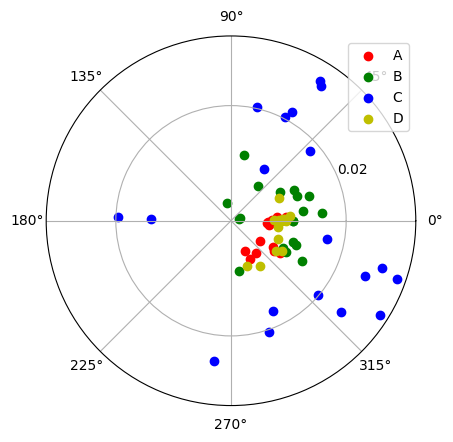

In [26]:
magErrorsA = angularInfoDictA['Mag Errors']  
magErrorsB = angularInfoDictB['Mag Errors']
magErrorsC = angularInfoDictC['Mag Errors']
magErrorsD = angularInfoDictD['Mag Errors']

angleErrorsA = angularInfoDictA['Angular Errors']
angleErrorsB = angularInfoDictB['Angular Errors']
angleErrorsC = angularInfoDictC['Angular Errors']
angleErrorsD = angularInfoDictD['Angular Errors']
#fig,ax = plt.subplot(111,polar= True)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ax.scatter(angleErrorsA,magErrorsA,color = 'r',label = "A")
ax.scatter(angleErrorsB,magErrorsB,color = 'g', label = 'B')
ax.scatter(angleErrorsC,magErrorsC,color = 'b', label = 'C')
ax.scatter(angleErrorsD,magErrorsD,color = 'y', label = 'D')
ax.set_rticks([0.02]) 
plt.legend()
plt.show()
